# Optimal Experimental Design for Conformer Search

Conformers define the different structures with the same bonding graph but different coordinates. 
Finding the lowest-energy conformation is a common task in molecular modeling, and one that often requires significant time to solve.
This practice problem is designed to explore the use of optimal experimental design techniques, which have [recently](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0354-7) [emerged](https://pubs.acs.org/doi/full/10.1021/acs.jctc.0c00648) as a potential tool for accelerating the conformer search.

The goal of this notebooks it to walk through the full process of performing active learning:
- [ ] Developing a design space and an initial training set
- [ ] Creating a machine learning model that reflects the underlying physics
- [ ] Writing the experimental design loop

**HINT**: The answer to the cells I've left you to fill in the cell below. Double-click that cell to see that answer (the part inside the `<pre></pre>` block)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from modAL.models import BayesianOptimizer
from modAL.disagreement import max_std_sampling
from modAL.acquisition import max_EI
from torchani.models import ANI2x
from scipy.optimize import minimize
from tqdm import tqdm, trange
import pickle as pkl
import pandas as pd
import numpy as np
import warnings

from confutils import get_initial_structure, evaluate_energy, relax_structure, detect_dihedrals, set_dihedrals

Fixing a random seed. Helps ensure that you do not get problematic initial data points for some sections.

In [2]:
np.random.seed(123)

## Problem Definition: Optimizing Cysteine
Cysteine is a very simple molecule with 5 rotatable bonds. It is a simple science problem for finding the lowest-energy state

<img src="https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/jctcce/2021/jctcce.2021.17.issue-3/acs.jctc.0c00648/20210421/images/large/ct0c00648_0002.jpeg" width=15%/>

(Figure from [Fang et al. (2021)](https://pubs.acs.org/doi/full/10.1021/acs.jctc.0c00648))
    

First step is to make a model for the molecule that we can use to compute the energy

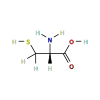

In [3]:
init_xyz, mol = get_initial_structure('C([C@@H](C(=O)O)N)S')  # Try with a more complicated molecule if you'd like!
mol

We use OpenBabel to generate an initial guess for the molecule structure and create a model for the molecule we can study to determine the dihedrals.

We can study the bonding graph to locate the angles.

In [4]:
dihedrals = detect_dihedrals(mol)
dihedrals

[DihedralInfo(chain=[7, 0, 1, 3], group={1, 2, 3, 4, 5, 6, 10, 11, 12}, type='backbone'),
 DihedralInfo(chain=[1, 0, 7, 13], group={13, 7}, type='backbone'),
 DihedralInfo(chain=[0, 1, 3, 4], group={10, 3, 4, 5}, type='backbone'),
 DihedralInfo(chain=[0, 1, 6, 11], group={11, 12, 6}, type='backbone'),
 DihedralInfo(chain=[1, 3, 5, 10], group={10, 5}, type='backbone')]

Now that we know these angles, we relax the structure and measure them to get an initial guess.

*Note*: We use [TorchANI](https://aiqm.github.io/torchani/index.html) to compute the energy of a structure using a machine-learned interatomic potential.

In [5]:
calc = ANI2x().ase()  # Get a ASE-compatable model using TorchANI

In [6]:
%%time
init_energy, init_xyz = relax_structure(init_xyz, calc)  # Use it to determine a ground-state

CPU times: user 24 s, sys: 24.1 s, total: 48.2 s
Wall time: 12.1 s


In [7]:
init_angles = np.array([di.get_angle(init_xyz) for di in dihedrals])

In [8]:
print(f'Initial guess {init_angles} = {init_energy} eV')

Initial guess [ 67.59223007 265.99442367 102.33649426  34.67307317   6.54273336] = -19641.708383166242 eV


We now have a function we can optimize!

## Step 1: Get some initial data
Our first step is to get enough data to start optimizing the molecule.

As we discussed in lecture, there are many ways to go about it: 

- [ ] Random selection! Hint: use [`np.random.uniform`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html)
- [ ] Latin Hypercube! Hint: Use https://spacefillingdesigns.nl/

Create a set of 4 points using random selection and save them as an array named `start_angles`.

In [9]:
raise NotImplementedError()

<pre style="color: white;">
start_angles = np.random.uniform(0, 360, size=(8, len(dihedrals)))
</pre>

Compute their energies

In [10]:
start_energies = np.array([evaluate_energy(a, init_xyz, dihedrals, calc) - init_energy for a in tqdm(start_angles)])

100%|██████████| 8/8 [00:47<00:00,  5.89s/it]


## Step 2: Learning a Surrogate Model
We need a model that we can train and evaluate quickly. Ideally, this model should give us uncertainties of their predictions.
For that choice, we use [Gaussian Process Regression](https://scikit-learn.org/stable/modules/gaussian_process.html) with a special choice of "kernel" to work best with angles as inputs.

Following [Fang et al. (2021)](https://pubs.acs.org/doi/full/10.1021/acs.jctc.0c00648), we use a "elementwise exponential sine kernel" that captures the idea that angles are periodic (e.g., 0 and 360 degrees ar ethe same. The following code shows how we implement it in Scikit-Learn.

In [11]:
def elementwise_expsine_kernel(x, y, gamma=1, p=360):
    """Compute the expoonential sine kernel
    
    Args:
        x, y: Coordinates to be compared
        gamma: Length scale of the kernel
        p: Periodicity of the kernel
    Returns:
        Kernel metric
    """
    
    # Compute the distances between the two points
    dists = np.subtract(x, y)
    
    # Compute the sine with a periodicity of p
    sine_dists = np.sin(np.pi * dists / p)
    
    # Return exponential of the squared kernel
    return np.sum(np.exp(-2 * np.power(sine_dists, 2) / gamma ** 2), axis=-1)

In [12]:
gpr = GaussianProcessRegressor(
    kernel=kernels.PairwiseKernel(metric=elementwise_expsine_kernel),
    n_restarts_optimizer=4, 
)

To illustrate it, let's generate some data where we vary an angle from 0 to 360 degrees

In [13]:
train_X = np.repeat(init_angles[None, :], 32, axis=0)  # Make a copy of the initial angles

In [14]:
train_X[:, 0] = np.linspace(0, 360, 32)  # Set the first angle to equally-spaced values between 0 and 360 (inclusive)

In [15]:
train_y = np.array([evaluate_energy(a, init_xyz, dihedrals, calc, relax=False) - init_energy for a in tqdm(train_X)])

100%|██████████| 32/32 [00:01<00:00, 26.55it/s]


Now, let's fit a model

In [16]:
subset_X, _, subset_y, _ = train_test_split(train_X, train_y, train_size=4)

In [17]:
gpr.fit(subset_X, subset_y)

GaussianProcessRegressor(kernel=PairwiseKernel(gamma=1.0, metric=<function elementwise_expsine_kernel at 0x7f5bb8ab2200>),
                         n_restarts_optimizer=4)

In [18]:
gpr.kernel_

PairwiseKernel(gamma=2.873952686699415, metric=<function elementwise_expsine_kernel at 0x7f5bb8ab2200>)

Create a Gaussian process model using a Radial Basis Function kernel

In [19]:
raise NotImplementedError()

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=32)

<pre style='color: white;'>
gpr_rbf = GaussianProcessRegressor(kernel=kernels.RBF(), n_restarts_optimizer=16)
gpr_rbf.fit(subset_X, subset_y)
</pre>

Plot the results

Text(0, 0.5, '$\\Delta E$')

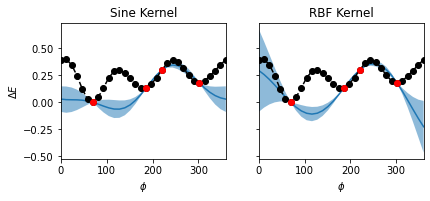

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5), sharey=True)

for ax, m, l in zip(axs, [gpr, gpr_rbf], ['Sine', 'RBF']):
    y_pred, y_std = m.predict(train_X, return_std=True)
    ax.plot(train_X[:, 0], y_pred)
    ax.fill_between(train_X[:, 0], y_pred + y_std, y_pred - y_std, alpha=0.5)

    ax.plot(train_X[:, 0], train_y, 'k--o')
    ax.plot(subset_X[:, 0], subset_y, 'ro')
    
    ax.set_title(f'{l} Kernel')

    ax.set_xlabel('$\\phi$')
    ax.set_xlim(0, 360)
axs[0].set_ylabel('$\Delta E$')

Note how the "sine kernel" has a function that obeys periodicity while the RBF kernel does not

### Step 3: Define a search space
The last ingredentient is to define a search space. The search space defines which new points we will consider at each step to 
For our purposes, let's just enumerate a large grid of spaces. 

*Advanced note*: Enumerating a large search space and evaluating every point is a brute force method for solving a global optimization problem. We can get away with it for this tutorial because our models are fast. However, more advanced toolkits (e.g., [BOTorch](https://botorch.org/docs/optimization)) use better strategies (e.g., multi-start derivative free optimizers).

In [21]:
grid_size = 6 # Number of points along each axis (avoid making it more than 10)

In [22]:
# Makes a grid with as many axes as our dihedral angles
grids = np.meshgrid(*[np.linspace(0, 360, grid_size)]*len(dihedrals))

In [23]:
search_points = np.array(list(zip(*[x.flatten() for x in grids])))
print(f'Generated {len(search_points)} points')

Generated 7776 points


Measure how long it takes to evaluate the full space

In [24]:
%%time
y_pred, y_std = gpr.predict(search_points, return_std=True)

CPU times: user 2.19 s, sys: 313 ms, total: 2.51 s
Wall time: 1.95 s


## Step 4: Define the optimizer
We now need to define the optimizer to use. We are going to use modAL again. 

Follow [the modAL tutorial](https://modal-python.readthedocs.io/en/latest/content/examples/bayesian_optimization.html) to define an optimizer that uses our `gpr` model we created earlier as the estimator, 
`start_angles` and `-1 * start_energies` as the initial training points,
and `max_EI` as the query strategy

In [25]:
raise NotImplementedError()

/home/lward/miniconda3/envs/oed/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


<pre style='color: white;'>
optimizer = BayesianOptimizer(
    estimator=gpr,
    X_training=start_angles,
    y_training=-1 * start_energies,
    query_strategy=max_EI
)
</pre>

Fill in the experimental design loop.

In [26]:
t = trange(32, desc=f'Best: {-optimizer.y_max:.2f} eV', leave=True)
for step in t:
    # Pick the best point to add to the dataet
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        raise NotImplementedError()
    
    # Compute the energies of those points
    best_energies = [
        init_energy - evaluate_energy(x, init_xyz, dihedrals, calc) for x in best_coords
    ]
    
    # Remove those points from the search space
    search_points = np.delete(search_points, best_point, axis=0)
    
    # Update the model
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        raise NotImplementedError()
        
    # Update the description
    t.set_description(f'Last: {-best_energies[0]:.2f} eV - Best: {-optimizer.y_max:.2f} eV')

Last: 0.04 eV - Best: -0.06 eV: 100%|██████████| 32/32 [09:16<00:00, 17.38s/it] 


<pre style='color: white;'>
best_point, best_coords = optimizer.query(search_points)  # First line
optimizer.teach(best_coords, best_energies)  # Second line
</pre>

Now that we have answer, find the nearest local minimum

In [27]:
print(f'Best solution pre-relaxation {optimizer.X_max}. DeltaE = {-optimizer.y_max} eV')

Best solution pre-relaxation [288. 288. 144. 288. 216.]. DeltaE = -0.06305030688236002 eV


In [28]:
final_xyz = set_dihedrals(init_xyz, optimizer.X_max, dihedrals)  # Set the angles to the best guess
final_energy, final_xyz = relax_structure(final_xyz, calc)  # Allow them all to relax

In [29]:
final_X = np.array([di.get_angle(final_xyz) for di in dihedrals])
print(f'Best solution: {final_X}. DeltaE = {final_energy - init_energy} eV')

Best solution: [297.90907782 288.8426488  119.82894171 275.3134752  179.12897269]. DeltaE = -0.2645728659372253 eV


Plot the optimizer performance

Text(0, 0.5, 'Energy - Initial Energy (Ha)')

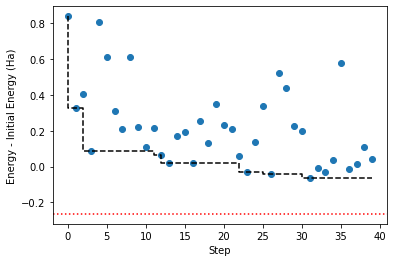

In [30]:
fig, ax = plt.subplots()

ax.plot(-optimizer.y_training, 'o', label='Guess')
ax.step(
    range(len(optimizer.y_training)), 
    np.minimum.accumulate(-optimizer.y_training),
    'k--',
    label='Cumulative Best'
)


ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [final_energy - init_energy]*2, 'r:', label='After Relax')

ax.set_xlabel('Step')
ax.set_ylabel('Energy - Initial Energy (Ha)')

It takes about 8 steps to find better candidates than OpenBabel and 20 to reach a probable global minimum.

You should have experienced:
- Creating an initial training set and machine learning model
- Defining an active learning policy with modAL
- Running an interative experimental design loop

If you would like to learn more, try making changes to each of these policies:
- Change the initial training set by adding more points or making them non-random
- Use a different acquisition function
- Pick more than one simulation during each iteration, or relax the dihedral angle and adding both the initial/relaxed structures